In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
import collections

from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus # must install
from IPython.display import Image  
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, mean_absolute_error
#rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

bookcolors = {'crimson': '#a50026', 'red': '#d73027', 'redorange': '#f46d43',
              'orange': '#fdae61', 'yellow': '#fee090', 'sky': '#e0f3f8', 
              'babyblue': '#abd9e9', 'lightblue': '#74add1', 'blue': '#4575b4',
              'purple': '#313695'}

def data():
#     df = pd.DataFrame(data={"sqfeet":[700, 750, 800, 850, 900,950,1000]})
#     df["rent"] = pd.Series([1160, 1160, 1175, 1200, 1280,1310,2000])
    df = pd.DataFrame(data={"sqfeet":[750, 800, 850, 900,1000]})
    df["rent"] = pd.Series([1160, 1175, 1200, 1250,2000])
    df = df.sort_values('sqfeet')
    return df

def get_leaf_samples(t):
    samples = collections.defaultdict(list)
    dec_paths = t.decision_path(df.sqfeet.values.reshape(-1, 1))
    for d, dec in enumerate(dec_paths):
        for i in range(t.tree_.node_count):
            if dec.toarray()[0][i]  == 1:
                samples[i].append(d)
    return samples

class L2Stump:
    def __init__(self, X, residual):
        """
        We train on the (X,residual) but only to get
        the regions in the leaves with y_i. Then we grab mean
        of residual, y_i - F_{m-1}, in that region.
        Split determined using DecisionTreeRegressor.
        """
        self.X, self.residual = X, residual
        self.tree_ = tree.DecisionTreeRegressor(max_depth=1)
        self.tree_.fit(X.values.reshape(-1, 1), residual)
        self.split = self.tree_.tree_.threshold[0]
        self.left = self.residual[self.X<self.split]
        self.right = self.residual[self.X>=self.split]
        
    def predict(self,x):
        if isinstance(x,np.ndarray) or isinstance(x,pd.Series):
            return np.array([self.predict(xi) for xi in x])
        lmean = np.mean(self.left)
        rmean = np.mean(self.right)
        return lmean if x < self.split else rmean
        
    
class L1Stump:
    def __init__(self, X, signs, residual):
        """
        We train on the (X,sign vector) but only to get
        the regions in the leaves with y_i. Then we grab median
        of residual, y_i - F_{m-1}, in that region.
        Split determined using DecisionTreeRegressor.
        """
        self.X, self.signs, self.residual = X, signs, residual
        self.tree_ = tree.DecisionTreeRegressor(max_depth=1)
        self.tree_.fit(X.values.reshape(-1, 1), signs)
        self.split = self.tree_.tree_.threshold[0]
        self.left = self.residual[self.X<self.split]
        self.right = self.residual[self.X>=self.split]
        
    def predict(self,x):
        if isinstance(x,np.ndarray) or isinstance(x,pd.Series):
            return np.array([self.predict(xi) for xi in x])
        lmed = np.median(self.left)
        rmed = np.median(self.right)
        return lmed if x < self.split else rmed

class GBM:
    def __init__(self, f0, stumps, eta):
        self.f0, self.stumps, self.eta = f0, stumps, eta
        
    def predict(self, x):
        delta = 0.0
        for t in self.stumps:
            delta += eta * t.predict(x)
        return self.f0 + delta
    
    def splits(self):
        s = []
        for t in self.stumps:
            s.append(t.split)
        return s

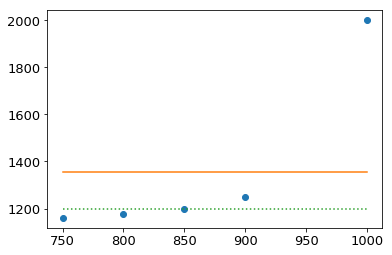

In [60]:
df = data()
df_l2 = df.copy()
df_l1 = df.copy()
plt.plot(df.sqfeet,df.rent,'o')

m = df.rent.mean()
mm = np.empty(len(df))
mm.fill(m)
plt.plot(df.sqfeet,mm)

md = df.rent.median()
md2 = np.empty(len(df))
md2.fill(md)
plt.plot(df.sqfeet,md2, linestyle=':')
plt.show()

## Show decision tree for L2 residual

In [61]:
def l2boost(df, ycol, eta, M):
    f0 = df[ycol].mean()
    df['F0'] = f0

    stumps = []
    for s in range(1,M+1):
        df[f'res{s}'] = df[ycol] - df[f'F{s-1}']
        t = L2Stump(df.sqfeet, df[f'res{s}'])
        stumps.append(t)
        df[f'delta{s}'] = t.predict(df.sqfeet)
        df[f'F{s}'] = df[f'F{s-1}'] + eta * df[f'delta{s}']

    return GBM(f0, stumps, eta)

def l1boost(df, ycol, eta, M):
    f0 = df[ycol].median()
    df['F0'] = f0

    stumps = []
    for s in range(1,M+1):
        df[f'res{s}'] = df[ycol] - df[f'F{s-1}']
        df[f'sign{s}'] = np.sign(df[f'res{s}'])
        t = L1Stump(df.sqfeet, df[f'sign{s}'], df[f'res{s}'])
        stumps.append(t)
        df[f'delta{s}'] = t.predict(df.sqfeet)
        df[f'F{s}'] = df[f'F{s-1}'] + eta * df[f'delta{s}']

    return GBM(f0, stumps, eta)

In [62]:
eta = 1.0
M = 5
gbm_l2 = l2boost(df_l2, 'rent', eta, M)
print(gbm_l2.splits())
mse = np.array([mean_squared_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)])
mse_sqrt = np.array(np.sqrt([mean_squared_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)]))
mae = np.array([mean_absolute_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)])
np.set_printoptions(precision=3)
print(mse)
print(mse_sqrt)
print(mae)

df_l2

[950.0, 825.0, 950.0, 875.0, 950.0]
[1.043e+05 9.338e+02 3.827e+02 2.909e+02 1.429e+02 8.747e+01]
[322.949  30.557  19.563  17.055  11.956   9.353]
[257.2    23.     16.833  13.     11.014   8.035]


,sqfeet,rent,F0,res1,delta1,F1,res2,delta2,F2,res3,delta3,F3,res4,delta4,F4,res5,delta5,F5
0,750,1160,1357.0,-197.0,-160.75,1196.25,-36.25,-28.750000,1167.500000,-7.500000,4.791667,1172.291667,-12.291667,-9.930556,1162.361111,-2.361111,3.723958,1166.085069
1,800,1175,1357.0,-182.0,-160.75,1196.25,-21.25,-28.750000,1167.500000,7.500000,4.791667,1172.291667,2.708333,-9.930556,1162.361111,12.638889,3.723958,1166.085069
2,850,1200,1357.0,-157.0,-160.75,1196.25,3.75,19.166667,1215.416667,-15.416667,4.791667,1220.208333,-20.208333,-9.930556,1210.277778,-10.277778,3.723958,1214.001736
3,900,1250,1357.0,-107.0,-160.75,1196.25,53.75,19.166667,1215.416667,34.583333,4.791667,1220.208333,29.791667,14.895833,1235.104167,14.895833,3.723958,1238.828125
4,1000,2000,1357.0,643.0,643.00,2000.00,0.00,19.166667,2019.166667,-19.166667,-19.166667,2000.000000,0.000000,14.895833,2014.895833,-14.895833,-14.895833,2000.000000


In [63]:
eta = 1.0
M = 5
gbm_l1 = l1boost(df_l1, 'rent', eta, M)
print(gbm_l1.splits())
mse = np.array([mean_squared_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)])
mse_sqrt = np.array(np.sqrt([mean_squared_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)]))
mae = np.array([mean_absolute_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)])
print(mse)
print(mse_sqrt)
print(mae)
df_l1

[825.0, 775.0, 950.0, 825.0, 775.0]
[128945.    113022.5   111961.25     545.938    502.109    519.453]
[359.089 336.188 334.606  23.365  22.408  22.792]
[183.    163.    161.5    12.25   11.125  10.75 ]


,sqfeet,rent,F0,res1,sign1,delta1,F1,res2,sign2,delta2,...,delta3,F3,res4,sign4,delta4,F4,res5,sign5,delta5,F5
0,750,1160,1200.0,-40.0,-1.0,-32.5,1167.5,-7.5,-1.0,-7.50,...,-1.875,1158.125,1.875,1.0,3.750,1161.875,-1.875,-1.0,-1.8750,1160.0000
1,800,1175,1200.0,-25.0,-1.0,-32.5,1167.5,7.5,1.0,3.75,...,-1.875,1169.375,5.625,1.0,3.750,1173.125,1.875,1.0,0.9375,1174.0625
2,850,1200,1200.0,0.0,0.0,50.0,1250.0,-50.0,-1.0,3.75,...,-1.875,1251.875,-51.875,-1.0,-1.875,1250.000,-50.000,-1.0,0.9375,1250.9375
3,900,1250,1200.0,50.0,1.0,50.0,1250.0,0.0,0.0,3.75,...,-1.875,1251.875,-1.875,-1.0,-1.875,1250.000,0.000,0.0,0.9375,1250.9375
4,1000,2000,1200.0,800.0,1.0,50.0,1250.0,750.0,1.0,3.75,...,746.250,2000.000,0.000,0.0,-1.875,1998.125,1.875,1.0,0.9375,1999.0625


950.0


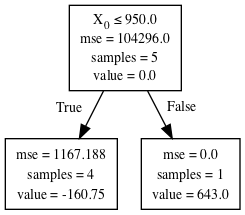

In [64]:
# t = tree.DecisionTreeRegressor(max_depth=1)
# t.fit(df.sqfeet.values.reshape(-1, 1), df.res1)
# t.predict(df.sqfeet.values.reshape(-1, 1))
# print(get_leaf_samples(t)[1], get_leaf_samples(t)[2])
# print(t.tree_.threshold[0])

t = L2Stump(df_l1.sqfeet, df_l2.res1)
print(t.split)

dot_data = StringIO()
tree.export_graphviz(t.tree_, dot_data, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


## Show decision tree for L1 residual

825.0


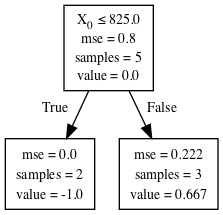

In [65]:
# t = tree.DecisionTreeRegressor(max_depth=1)
# t.fit(df.sqfeet.values.reshape(-1, 1), df.sign1)
# t.predict(df.sqfeet.values.reshape(-1, 1))
# print(get_leaf_samples(t)[1], get_leaf_samples(t)[2])
# print(t.tree_.threshold[0])

t = L1Stump(df_l1.sqfeet, df_l1.sign1, df_l1.res1)
print(t.split)

dot_data = StringIO()
tree.export_graphviz(t.tree_, dot_data, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())